<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание 4. Сравнение алгоритмов классификации на наборах данных репозитория UCI</center>

В рамках данного задания нужно выбрать один из наборов данных для задачи классификации из [репозитория UCI](http://archive.ics.uci.edu/ml/), выбрать несколько алгоритмов классификации и сравнить их на этом наборе данных.

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


**Выберите любой набор данных для задачи классификации из [репозитория UCI](http://archive.ics.uci.edu/ml/) и загрузите его, используя функцию urlopen. Конечно, можно и скачать данные, а потом открыть csv-файл с помощью pandas.**

In [2]:
'''
Таким методом почему-то не грузилось. Но pandas.read_csv, согласно документации, это умеет делать сам:
 >>> The string could be a URL. Valid URL schemes include http, ftp, s3, and file.
'''
# import sys
# if sys.version_info.major == 2:
#     from urllib import urlopen
# elif sys.version_info.major == 3:
#     from urllib.request import urlopen
# raw_data = urlopen(url)
# data = np.loadtxt(raw_data, delimiter=",")


url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data'
'''
The data are generated to simulate registration of high energy gamma particles
in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique

Attribute Information:

1. fLength: continuous # major axis of ellipse [mm] 
2. fWidth: continuous # minor axis of ellipse [mm] 
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot] 
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1: continuous # ratio of highest pixel over fSize [ratio] 
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: continuous # 3rd root of third moment along major axis [mm] 
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm] 
9. fAlpha: continuous # angle of major axis with vector to origin [deg] 
10. fDist: continuous # distance from origin to center of ellipse [mm] 
11. class: g,h # gamma (signal), hadron (background) 
'''
import pandas as pd
features = [
    'fLength',
    'fWidth', 
    'fSize', 
    'fConc', 
    'fConc1', 
    'fAsym',
    'fM3Long',
    'fM3Trans',
    'fAlpha',
    'fDist',
    'class']
data = pd.read_csv(url, names=features)

**Выведите основные характеристики выборки (число объектов, признаков, число классов) и разделите выборку на обучение и контроль с помощью функции train_test_split**

In [3]:
from sklearn.model_selection import train_test_split

# Print basic data stats: 
# number of objects, number of features, number of classes 
print('Число объектов: {},'.format(data.shape[0]))
print('Число признаков: {},'.format(data.shape[1]))
print('Число классов: {}'.format(data['class'].nunique()))

# Extract objects and labels from data
# 1 - signal, 0 - background
y = data['class'].apply(lambda c: 0 if c == 'h' else 1)
X = data.drop(['class'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Число объектов: 19020,
Число признаков: 11,
Число классов: 2


## 1. Классификаторы без настройки параметров 

**Выберите несколько (2-3) классификаторов из sklearn. Для удобства (чтобы не переписывать один и тот же код для каждого классификатора) можно создать список классификаторов, который, например, может состоять из пар вида (classifier_instance(), 'classifier name').**

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

classifiers = [
    (LogisticRegression(random_state=42),
     'logit',
     {            
           'C': np.logspace(-4, 5, 10)           
     }),
    (KNeighborsClassifier(),
     'knn',
     {
           'n_neighbors': list(range(3, 12, 2))            
     }),
    (DecisionTreeClassifier(random_state=42),
     'tree', 
     {
           'max_depth': list(range(1,11)), 
           'min_samples_leaf': list(range(1,11))
     }),
#     (SVC(probability=True, random_state=42), 'svm')
]

accuracy_without_options = {}

**С помощью 5-кратной кросс-валидации оцените качество каждого классификатора на обучающей выборке. Используйте функцию cross_val_score. Попробуйте использовать разные метрики качества (параметр scoring)**

In [4]:
[[] for _ in range(3)] == [[]] * 3

True

In [5]:
%%time
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def mean_cross_val_score_by_scoring(classifier, X, y, cv, scoring):
    clf_scores = cross_val_score(classifier, X, y, cv=cv, scoring=scoring)
    return np.mean(clf_scores)    

n_folds = 5
scorings = ['accuracy', 'neg_log_loss', 'f1']

scores = dict(zip(scorings, [[] for _ in range(len(scorings))]))

skf = StratifiedKFold(n_splits=n_folds)

for product in itertools.product(classifiers, scorings):
    # Do it for each classifier
    mean = mean_cross_val_score_by_scoring(product[0][0], X_train, y_train, cv=skf, scoring=product[1])
    scores[product[1]].append(mean)

# Print the name of classifier with
# the best score and the score
def print_best(scores):    
    for scoring in scores:
        print('Метрика качества: {}'.format(scoring))
        print('\tЛучший классификатор: {}, со значением: {}'\
              .format(classifiers[np.argmax(scores[scoring])][1], max(scores[scoring])))
        
print_best(scores)

Метрика качества: f1
	Лучший классификатор: knn, со значением: 0.858517345401018
Метрика качества: neg_log_loss
	Лучший классификатор: logit, со значением: -0.45968639260089716
Метрика качества: accuracy
	Лучший классификатор: tree, со значением: 0.8142560397649264
CPU times: user 6.51 s, sys: 6.99 s, total: 13.5 s
Wall time: 5.56 s


---

# Review

Все хорошо.

В питоне много разного сахара, какие-то выражения можно записать чуть проще

```python
>>> [[] for _ in range(len(scorings))] == [[]] * len(scorings)
True
```

Вместо 
```python
for product in itertools.product(classifiers, scorings):
    product[0]
    ...
    product[1]
```
можно написать:
```python
for classifier, score in itertools.product(classifiers, scorings):
    ...
```
Тогда можно будет избежать использования малопонятных многомерных индексов типа `mylist[1][0][3]`

А в целом все прям хорошо. Только можно еще больше облегчить себе жизнь, если не искать элементы с максимальным значением метрики через `np.argmax`, а просто загнать все данные в `pd.DataFrame` и отсортировать по значению метрики.

---

In [6]:
%%time
'''
Так как cross_val_score выполняется на этом датасете для SVM ~ 1 мин, выделил в отдельнуя ячейку :)
Примерное выполнение ~ 10 мин.
'''
def long_time_calculation(scorings):
    
    svm = SVC(probability=True, random_state=42)
    scores = dict(zip(scorings, np.nan))
    for scoring in scorings:      
        mean = mean_cross_val_score_by_scoring(svm, X_train, y_train, cv=skf, scoring=scoring)     
        scores[scoring] = mean 

    for scoring in scores:
        print('Метрика качества: {}'.format(scoring))
        print('\Классификатор: svm, со значением: {}'\
              .format(scores[scoring]))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


**Обучите те же классификаторы без параметров на всей обучающей выборке и проверьте их качество на тестовой выборке. Является ли лучшим классификатор, который имеет наибольшее качество на кросс-валидации?**

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

scores = dict(zip(scorings, [[] for _ in range(len(scorings))]))

for classifier in classifiers:
    # Do it for each classifier
    clf = classifier[0]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_sc = accuracy_score(y_test, y_pred)
    f1_sc = f1_score(y_test, y_pred)
    log_loss_sc = log_loss(y_test, y_pred)
    scores['accuracy'].append(acc_sc)
    scores['f1'].append(f1_sc)
    scores['neg_log_loss'].append(-log_loss_sc)
        
    accuracy_without_options[classifier[1]] = acc_sc

# Print the name of classifier with
# the best score and the score
print_best(scores)

Метрика качества: f1
	Лучший классификатор: tree, со значением: 0.8640434192672998
Метрика качества: neg_log_loss
	Лучший классификатор: tree, со значением: -6.065235779122802
Метрика качества: accuracy
	Лучший классификатор: tree, со значением: 0.8243953732912723


Для метрик 'accuracy' и 'f1' лучшие классификаторы совпали. Для метрики 'neg_log_loss' классификаторы разные.

## 2. Классификаторы с настройкой параметров 

**Настройте параметры выбранных вами алгоритмов с помощью GridSearchCV и выберите лучший классификатор**

In [8]:
%%time
from sklearn.model_selection import GridSearchCV 

n_folds = 5
scores = dict(zip(scorings, [[] for _ in range(len(scorings))]))

for product in itertools.product(classifiers, scorings):
    # Do it for each classifier
    clf_params = product[0][2]
    grid = GridSearchCV(product[0][0],
                        clf_params, 
                        verbose=False,
                        n_jobs=-1,
                        cv=5,
                        scoring=product[1])
    grid.fit(X_train, y_train)
    clf_best_score = grid.best_score_
    scores[product[1]].append(clf_best_score)

# Print the name of classifier with
# the best score, the score and the params
print_best(scores)

Метрика качества: f1
	Лучший классификатор: tree, со значением: 0.8873474414409485
Метрика качества: neg_log_loss
	Лучший классификатор: tree, со значением: -0.4183606553270574
Метрика качества: accuracy
	Лучший классификатор: tree, со значением: 0.846928045666216
CPU times: user 5.19 s, sys: 684 ms, total: 5.87 s
Wall time: 40.8 s


**Для лучшего классификатора и набора параметров для него выберите более мелкую сетку (для того чтобы уточнить лучшие значения параметров). Для этого классификатора настройте параметры по обучающей выборке с помощью GridSearchCV. Постройте график зависимости среднего качества на кросс-валидации от значений параметров**

Лучшим по всем метрикам получился DecisionTreeClassifier, попробуем увеличить диапазон параметров.

Лучшее значение качества: 0.846928045666216
Лучшие параметры: {'max_depth': 8, 'min_samples_leaf': 4}
CPU times: user 4.57 s, sys: 304 ms, total: 4.87 s
Wall time: 39.2 s


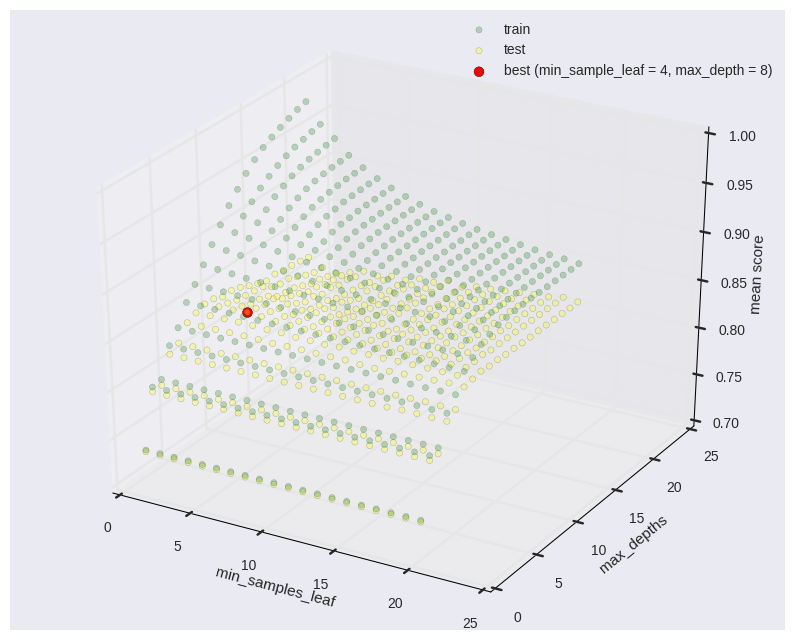

In [9]:
%%time
from mpl_toolkits.mplot3d import Axes3D

clf_params = {
           'max_depth': list(range(1,21)), 
           'min_samples_leaf': list(range(1,21))
     }
grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                   clf_params, 
                   verbose=False,
                   n_jobs=-1,
                   cv=5,
                   scoring='accuracy')
grid.fit(X_train, y_train)

clf_best_score = grid.best_score_
clf_best_params = grid.best_params_
clf_best = grid.best_estimator_

min_samples_leafs = [param['min_samples_leaf'] for param in grid.cv_results_['params']]
max_depths = [param['max_depth'] for param in grid.cv_results_['params']]

mean_train_scores = grid.cv_results_['mean_train_score']
mean_test_scores = grid.cv_results_['mean_test_score']

fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

ax.scatter(min_samples_leafs, max_depths, mean_train_scores, label='train', c='green', alpha=0.25)
ax.scatter(min_samples_leafs, max_depths, mean_test_scores, label='test', c='yellow', alpha=0.30)
best_sample_leaf = clf_best_params['min_samples_leaf']
best_max_depth = clf_best_params['max_depth']
ax.scatter(best_sample_leaf, best_max_depth, clf_best_score,\
           c='red', label='best (min_sample_leaf = {}, max_depth = {})'\
           .format(best_sample_leaf, best_max_depth), s=50)
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('max_depths')
ax.set_zlabel('mean score')
ax.legend()

print('Лучшее значение качества: {}'.format(clf_best_score))
print('Лучшие параметры: {}'.format(clf_best_params))

**Для полученной модели посчитайте качество на тестовой выборке и сравните его с качеством, полученным без настройки параметров**

In [10]:
y_pred = clf_best.predict(X_test)
acc_sc = accuracy_score(y_test, y_pred)

print("Качество настроенной модели: {}".format(acc_sc))
print("Качество модели без настройки параметров: {}".format(accuracy_without_options['tree']))

Качество настроенной модели: 0.8456011216263583
Качество модели без настройки параметров: 0.8243953732912723


Качество настроенной модели выше качества модели без настройки.

**Можно поварьировать параметр scoring и позапускать написанный код ещё раз. Изменится ли лучший классификатор?**

На этом датасете лучшим по всем метрикам оказался классификатор DecisionTreeClassifier.

---

# Review

Очень хорошо, оценка 10/10

---

## Ссылки:

 - <a href="http://archive.ics.uci.edu/ml/">UCI Machine Learning Repository</a> 
 - <a href="http://scikit-learn.org/stable/index.html">Scikit-learn documentation</a>